In [5]:
 #### EDA Mall Customer Segmentation
    
    

In [38]:
#Import packages
import pandas as pd
import numpy as np
from collections import Counter

#For visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt


#For other models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from kmodes.kmodes import KModes
from kmodes import kprototypes

#Calculate distance matrix to cluster mixed data type
from scipy.spatial import distance_matrix

#For calculate solhouette_score
from sklearn.metrics import silhouette_score

#For Encoding
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


# For metrics and helpful functions
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

#warning
import warnings

In [39]:
file_path = "./data/Mall_Customers.csv"
customer_data = pd.read_csv(file_path)

In [40]:
customer_data.head(10)
print(customer_data.columns)

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')


In [41]:
### Renaming the column 
customer_data = customer_data.rename(columns={"Annual Income (k$)":"Annual Income","Spending Score (1-100)":"Spending Score"})

#Display top 10 bottom data
customer_data.tail(10)

,CustomerID,Gender,Age,Annual Income,Spending Score
190,191,Female,34,103,23
191,192,Female,32,103,69
192,193,Male,33,113,8
193,194,Female,38,113,91
194,195,Female,47,120,16
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


In [42]:
# Check if the dataset contains null or empty values
customer_data.isna().sum()

CustomerID        0
Gender            0
Age               0
Annual Income     0
Spending Score    0
dtype: int64

In [43]:
customer_data.duplicated().sum()

0

In [44]:
clean_data = customer_data.drop(['CustomerID'],axis=1)

In [45]:
clean_data.describe()

,Age,Annual Income,Spending Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


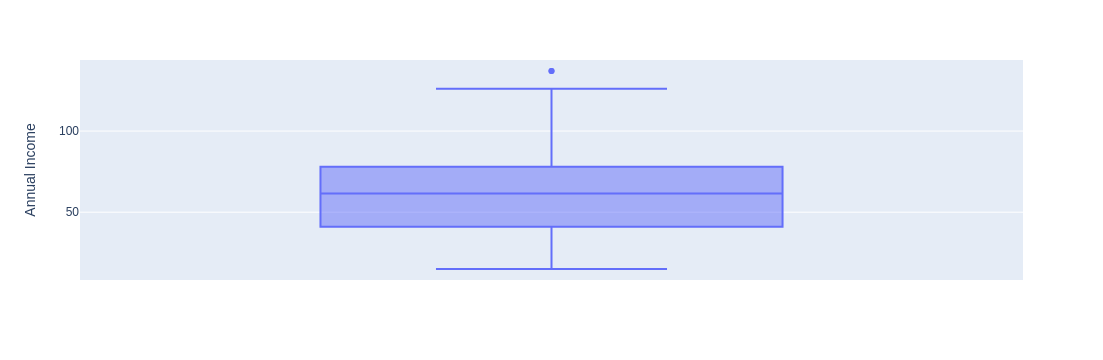

In [46]:
# Create  subplot to visualize  outliers
fig = px.box(clean_data, y="Annual Income")
fig.show()

In [47]:
#Create function to calculate the upper limit, lower limit, number of outliers and their % in dataset for each specified column
def calculate_outliers(df, column_names):
    """
    Calculate upper limit, lower limit, number of outliers and the % in dataset for each specified column .

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data and need to calculate outliers
    - column_names (list): A list of column names to analyze for outliers.

    Returns:
    - pd.DataFrame: A DataFrame containing information about outliers for each specified column.
      Columns: ['Column', 'Number of Outliers', '% Outliers', 'Lower Limit', 'Upper Limit']
    """

    # Calculate the number of columns and rows for subplots
    col_len = len(column_names)
    if col_len % 2 == 0:
      num_columns = 2
      num_rows = col_len // 2
    else:
      num_columns = col_len
      num_rows = 1


    # Initialize a list to store outlier information for each column
    outlier_data = []

    # Iterate over column_names and create subplots
    for i, column_name in enumerate(column_names):
        data = df[column_name]

        # Calculate quartiles and interquartile range using np.percentile
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1

        # Define lower and upper limits for outlier detection
        low_lim, upp_lim = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        # Find and display outliers
        outliers = df[(data < low_lim) | (data > upp_lim)][column_name]
        num_outliers = len(outliers)
        percent_outliers = round(num_outliers / len(df) * 100, 1)

        # Append outlier information to the list
        outlier_data.append([column_name, num_outliers, percent_outliers, round(low_lim, 1), round(upp_lim, 1)])


    # Combine the outlier information into a DataFrame
    outlier_df = pd.DataFrame(outlier_data,
                              columns = ['Column', 'Number of Outliers', '% Outliers', 'Lower Limit', 'Upper Limit'])
    return outlier_df

In [48]:
#Define colum to check
col = ["Annual Income"]
outliers_table = calculate_outliers(clean_data,col)
outliers_table

,Column,Number of Outliers,% Outliers,Lower Limit,Upper Limit
0,Annual Income,2,1.0,-13.2,132.8


In [49]:
clean_data['Gender'].value_counts()

Gender
Female    112
Male       88
Name: count, dtype: int64

/home/albin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



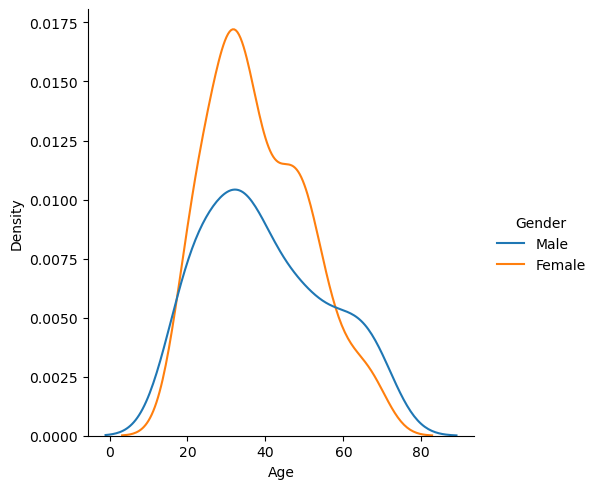

In [50]:
sns.displot(clean_data,x='Age',hue='Gender',kind='kde')

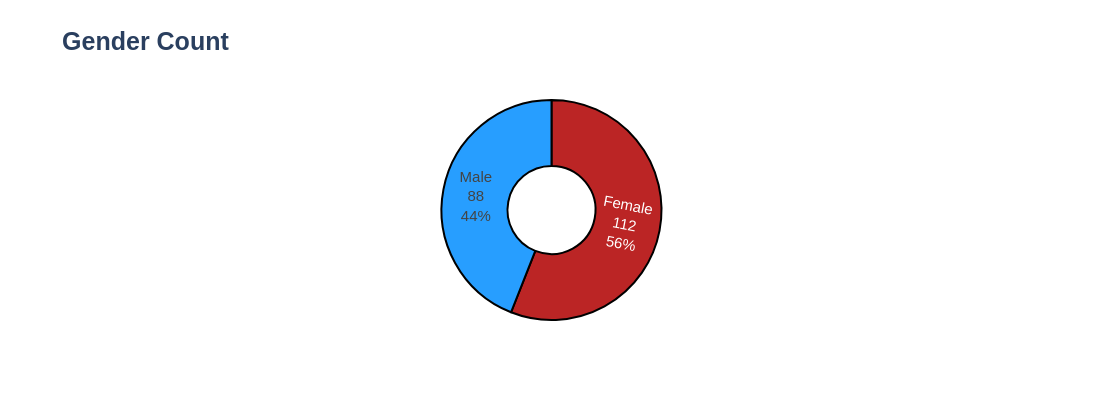

In [51]:
# Visualize the gender distribution

gender_dis = clean_data['Gender'].value_counts()


# Visualise in pie chart

fig = px.pie(
    names = gender_dis.index,
    values=gender_dis.values,
    title='<b> Gender Count </b>',
    hole=.4,
    width = 400,
    height=400
)
fig.update_traces(textposition='inside',
                  textinfo='percent+label+value',
                  textfont_size=15,
                  marker=dict(colors=['#BB2525', '#279EFF'], line=dict(color='#000000', width=2)))
fig.update_layout(title={'font': {'size': 25}}, showlegend=False)
fig.show()

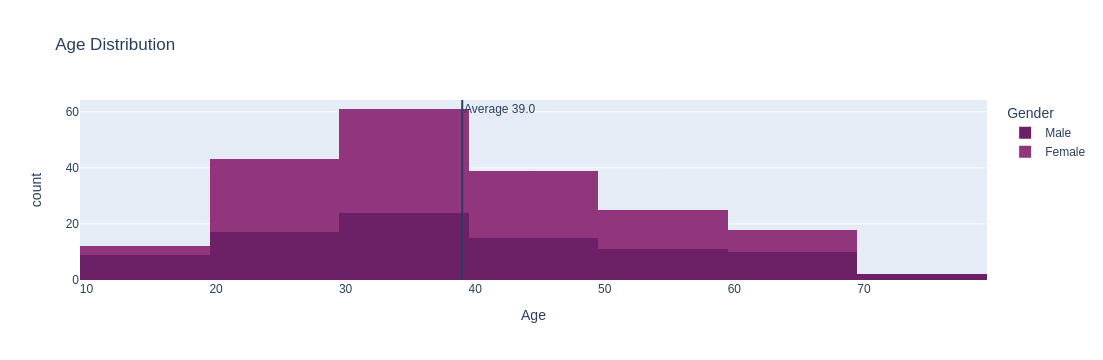

In [52]:
avg_cost = clean_data['Age'].mean().round(0)

fig = px.histogram(
    clean_data, 
    x = 'Age',
    color='Gender',
    # labels={'comb08': "Annual Fuel Cost"},
    nbins=10,
    title='Age Distribution',
    color_discrete_sequence=px.colors.sequential.Magenta_r,
)
fig.add_vline(
    x = avg_cost,
    annotation_text = f'Average {avg_cost}'
)
fig.show()

In [53]:
clean_data.tail()

,Gender,Age,Annual Income,Spending Score
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18
199,Male,30,137,83


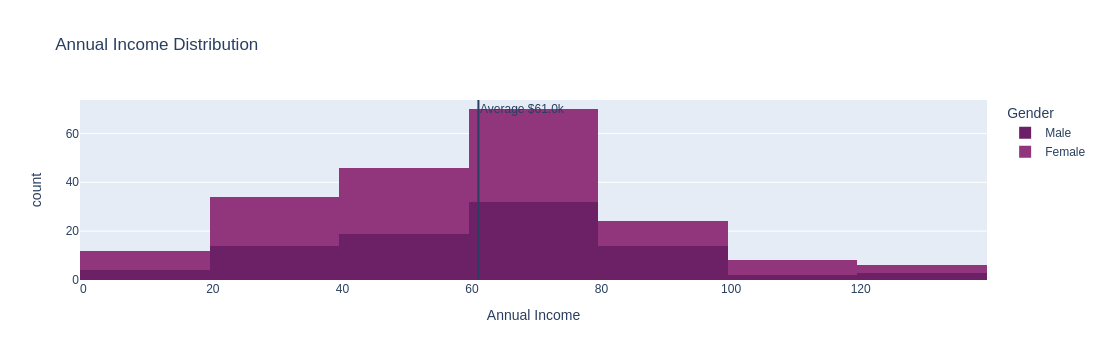

In [54]:
avg_cost = clean_data['Annual Income'].mean().round(0)

fig = px.histogram(
    clean_data, 
    x = 'Annual Income',
    color='Gender',
    # labels={'comb08': "Annual Fuel Cost"},
    nbins=10,
    title='Annual Income Distribution',
    color_discrete_sequence=px.colors.sequential.Magenta_r,
)
fig.add_vline(
    x = avg_cost,
    annotation_text = f'Average ${avg_cost}k'
)
fig.show()

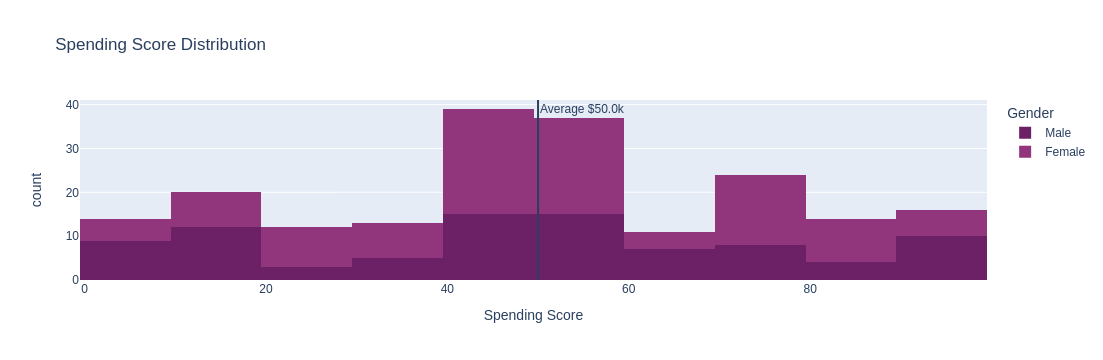

In [55]:
avg_cost = clean_data['Spending Score'].mean().round(0)

fig = px.histogram(
    clean_data, 
    x = 'Spending Score',
    color='Gender',
    # labels={'comb08': "Annual Fuel Cost"},
    nbins=10,
    title='Spending Score Distribution',
    color_discrete_sequence=px.colors.sequential.Magenta_r,
)
fig.add_vline(
    x = avg_cost,
    annotation_text = f'Average ${avg_cost}k'
)
fig.show()

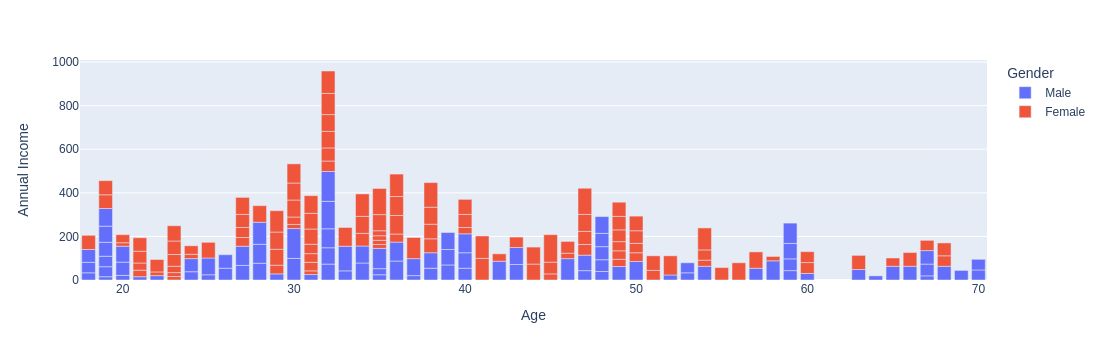

In [56]:
fig = px.bar(
    clean_data, 
    x = 'Age',
    y = 'Annual Income',
    color='Gender',
)
fig.show()

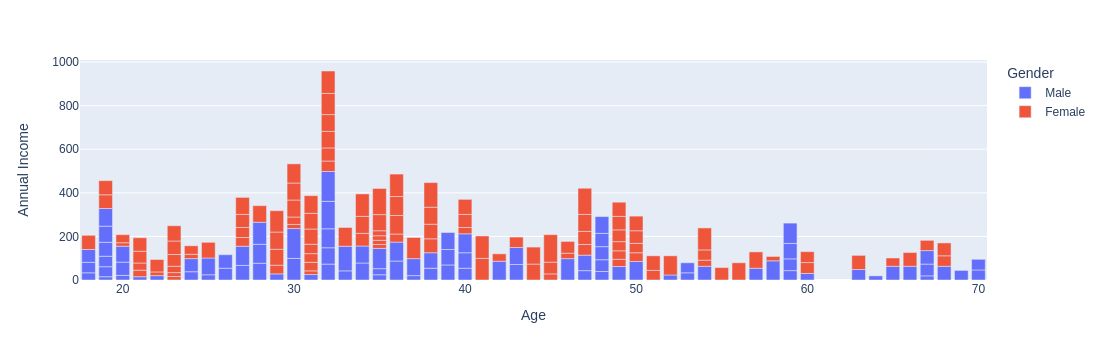

In [57]:
import plotly.graph_objects as go

fig = px.bar(
    clean_data,
    x='Age',
    y='Annual Income',
    color = 'Gender'
    )

fig.show()

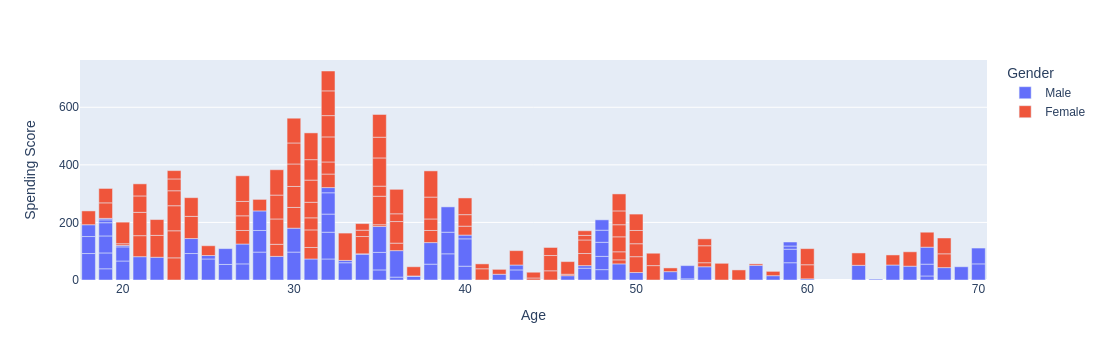

In [58]:
import plotly.graph_objects as go

fig = px.bar(
    clean_data,
    x='Age',
    y='Spending Score',
    color = 'Gender'
    )

fig.show()

<Axes: >

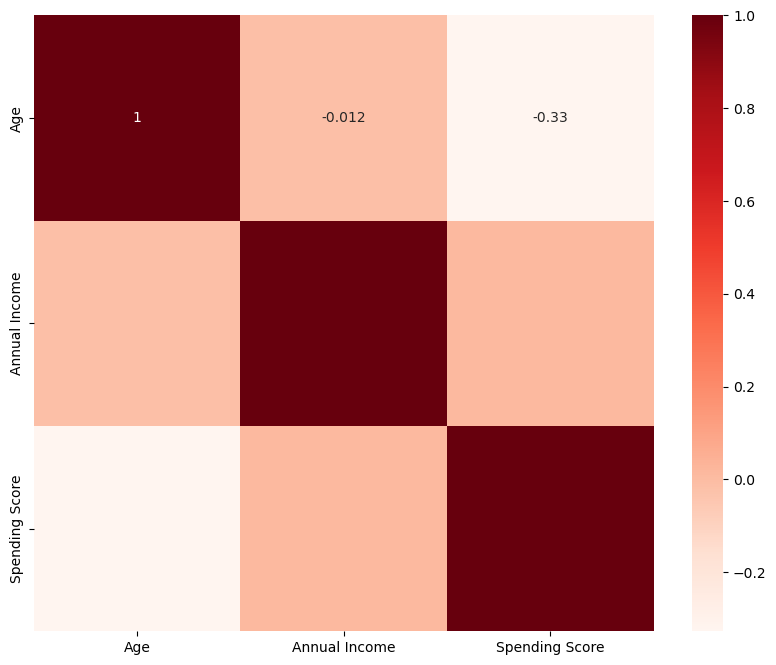

In [59]:
#Create heatmap to check correlation of all numerical features
plt.figure(figsize=(10,8))
sns.heatmap(clean_data.drop('Gender',axis=1).corr(), annot=True, cmap=plt.cm.Reds)

In [60]:
#Define number of cluster want to fit and evaluate
num_clusters = [i for i in range(2, 16)]
num_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [61]:
#Create subset dataframe with 2 features: `Annual Income` and `Spending Score`
X_2dim = clean_data[['Annual Income','Spending Score']]
X_2dim

,Annual Income,Spending Score
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


In [62]:
#Standarize the data
X_2dim_scaled = StandardScaler().fit_transform(X_2dim)
#Transform to dataframe
X_2dim_scaled = pd.DataFrame(X_2dim_scaled,columns = X_2dim.columns)
#Double check dataframe
X_2dim_scaled.describe()

,Annual Income,Spending Score
count,2.000000e+02,2.000000e+02
mean,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00
min,-1.738999e+00,-1.910021e+00
25%,-7.275093e-01,-5.997931e-01
50%,3.587926e-02,-7.764312e-03
75%,6.656748e-01,8.851316e-01
max,2.917671e+00,1.894492e+00


In [63]:
#Funtion to fit kmeans and evaluate inertia for different number of cluster

def kmeans_inertia(num_clusters, x_vals):
  """
  Accepts as arguments list of ints and data array.
  Fits a KMeans model where k = each value in the list of ints.

  Parameters:
    - num_clusters: number of cluster will fit and evaluate inertia
    - x_vals: the dataframe need to fit and evaluate inertia

  Returns list of inertia value for each k using KMeans model to fit.
  """
  inertia = []
  for num in num_clusters:
    kms = KMeans(n_clusters=num, random_state=20)
    kms.fit(x_vals)
    inertia.append(kms.inertia_)

  return inertia

In [64]:
#Call kmeans_inertia function to return list of inertia
inertia_2dim = kmeans_inertia(num_clusters,X_2dim)
#Display list of inertia
inertia_2dim

/home/albin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/albin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/albin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/albin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/albin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:14

[183116.4295463669,
 106348.37306211119,
 73679.78903948834,
 44448.45544793371,
 37239.835542456036,
 30259.65720728547,
 24990.4343103969,
 21818.11458845218,
 20022.611567624397,
 17518.643456567686,
 15845.619372815674,
 14578.414691133241,
 12775.343451156685,
 12087.14728600454]

/home/albin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/albin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



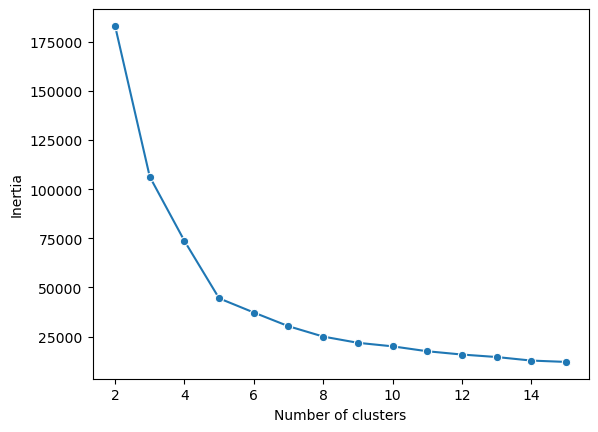

In [65]:
#Create line plot to visualize inertia and number of cluster respectively
plot = sns.lineplot(x=num_clusters, y=inertia_2dim, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

In [66]:
#Fit a 5-clusters model
kmeans5_2dim = KMeans(n_clusters=5, n_init='auto', random_state=50)
kmeans5_2dim.fit(X_2dim_scaled)

KMeans(n_clusters=5, n_init='auto', random_state=50)

In [67]:
#Use Counter to count number of data points in each cluster
Counter(kmeans5_2dim.labels_)

Counter({0: 81, 2: 39, 3: 35, 4: 23, 1: 22})

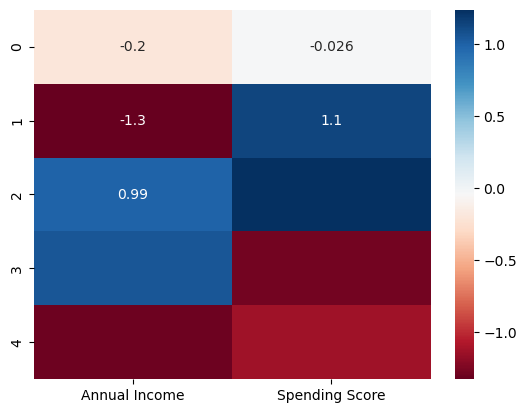

In [68]:
#Create heatmap to visulize cluster center of each cluster
clus_cen5_2dim = pd.DataFrame(kmeans5_2dim.cluster_centers_, columns=X_2dim_scaled.columns)
sns.heatmap(clus_cen5_2dim, cmap='RdBu', annot=True);

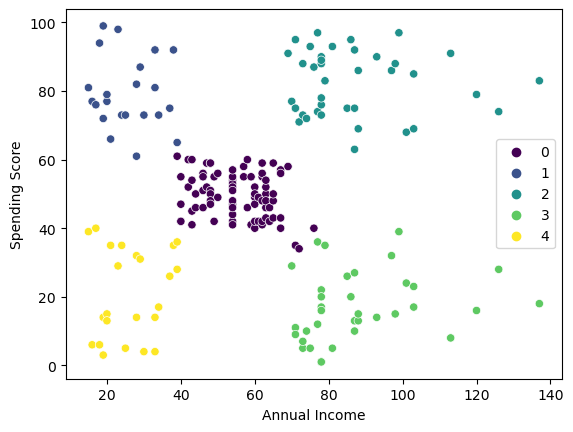

In [70]:
#Create scatterplot to visualize clusters in 2 dimensions
sns.scatterplot(x='Annual Income',
                y='Spending Score',
                hue=kmeans5_2dim.labels_,
                data=clean_data,
                palette='viridis');